In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [14]:
def load_embeddings(experiment_dir, layer_names):
    """
    Load embeddings for specified layers from a given experiment directory.
    """
    embeddings = {}
    for layer in layer_names:
        layer_path = os.path.join(experiment_dir, f"{layer}.npy")
        if os.path.exists(layer_path):
            embeddings[layer] = np.load(layer_path)
        else:
            print(f"Warning: {layer_path} not found.")
    return embeddings

def compute_sorted_eigenvalues(embeddings, center=True):
    """
    Computes the eigenvalues of the covariance matrix of the embeddings.
    
    Args:
        embeddings (np.ndarray): Array of shape [num_examples, representation_dim].
        center (bool): If True, subtract the mean of each column.
    
    Returns:
        sorted_eigvals (np.ndarray): Eigenvalues sorted in descending order.
    """
    # Center the embeddings if required.
    if center:
        X_centered = embeddings - np.mean(embeddings, axis=0, keepdims=True)
    else:
        X_centered = embeddings
    
    # Compute the covariance matrix. Using rowvar=False means each column is a variable.
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # For a symmetric covariance matrix, use eigh (which returns real eigenvalues)
    eigvals, _ = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues in descending order
    sorted_eigvals = np.sort(eigvals)[::-1]
    return sorted_eigvals

def plot_scree(sorted_eigvals, layer_name="Layer", model_name="Model", cumulative=False):
    """
    Plots a scree plot of the sorted eigenvalues.
    
    Args:
        sorted_eigvals (np.ndarray): Sorted eigenvalues (descending order).
        layer_name (str): Name of the layer (for the title).
        model_name (str): Name of the model (for the title).
        cumulative (bool): If True, plots cumulative explained variance.
    """
    indices = np.arange(1, len(sorted_eigvals) + 1)
    
    if cumulative:
        # Compute cumulative explained variance
        cum_explained = np.cumsum(sorted_eigvals) / np.sum(sorted_eigvals)
        plt.figure(figsize=(8, 6))
        plt.plot(indices, cum_explained, marker='o', linestyle='-')
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title(f"Cumulative Explained Variance\n{model_name} - {layer_name}")
        plt.grid(True)
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        plt.plot(indices, sorted_eigvals, marker='o', linestyle='-')
        plt.xlabel("Component Index")
        plt.ylabel("Eigenvalue")
        plt.title(f"Scree Plot\n{model_name} - {layer_name}")
        plt.grid(True)
        plt.show()

def compute_effective_rank(sorted_eigvals):
    """
    Computes the effective rank of the representation based on the eigenvalue spectrum.
    
    Effective rank is defined as exp(-∑ p_i log(p_i)), where p_i are the normalized eigenvalues.
    
    Args:
        sorted_eigvals (np.ndarray): Sorted eigenvalues (descending order).
        
    Returns:
        effective_rank (float): The effective rank of the representation.
    """
    eps = 1e-12  # small constant to avoid division by zero and log(0)
    total = np.sum(sorted_eigvals) + eps
    p = sorted_eigvals / total
    entropy = -np.sum(p * np.log(p + eps))
    effective_rank = np.exp(entropy)
    return effective_rank

def extract_label(exp_dir):
    match = re.search(r'cut_tree_\d+', exp_dir)
    if match:
        return match.group(0)
    return os.path.basename(exp_dir)

def plot_effective_rank_vs_layer_multi(experiment_dirs, layer_names, model_label_func=None):
    """
    For a list of experiment directories (each corresponding to one model),
    load the embeddings for the given layers, compute the effective rank for each layer,
    and plot effective rank vs. layer for all models in one plot.
    
    Args:
        experiment_dirs (list): List of experiment directory paths.
        layer_names (list): List of layer names (order is preserved).
        model_label_func (callable, optional): A function that takes an experiment directory
            string and returns a label for that model. If None, the basename of the directory is used.
    """
    effective_ranks_dict = {}
    
    for exp_dir in experiment_dirs:
        # Load embeddings for the model
        embeddings = load_embeddings(exp_dir, layer_names)
        effective_ranks = []
        for layer in layer_names:
            if layer in embeddings:
                # embeddings[layer] is assumed to have shape [num_examples, representation_dim]
                sorted_eigvals = compute_sorted_eigenvalues(embeddings[layer])
                eff_rank = compute_effective_rank(sorted_eigvals)
                effective_ranks.append(eff_rank)
            else:
                effective_ranks.append(np.nan)
        
        # Generate a label for this model
        if model_label_func is not None:
            label = model_label_func(exp_dir)
        else:
            # Default: use the basename of the directory
            label = os.path.basename(exp_dir)
        effective_ranks_dict[label] = effective_ranks

    # Plot effective rank vs. layer for all models on one plot
    plt.figure(figsize=(12, 8))
    x = np.arange(len(layer_names))
    for label, eff_ranks in effective_ranks_dict.items():
        plt.plot(x, eff_ranks, marker='o', label=label)
    
    plt.xticks(x, layer_names, rotation=45, ha='right')
    plt.xlabel("Layer")
    plt.ylabel("Effective Rank")
    plt.title("Effective Rank vs. Layer Across Models")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
experiment_dirs = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_01-33-16',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_02-12-27',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_02-54-27',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_03-35-19'
]


In [5]:
experiment_dir1 = '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_03-35-19'
experiment_dir2 = '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_03-35-19'

# Specify the layers you want to compare
layer_names = ['gnn_1_head_1',
'gnn_1_head_2',
'gnn_1_head_3',
'gnn_1_head_4',
'gnn_2_head_1',
'gnn_2_head_2',
'gnn_2_head_3',
'gnn_2_head_4',
'gnn_3_head_1',
'gnn_3_head_2',
'gnn_3_head_3',
'gnn_3_head_4',
'head_head_fc1',
'head_skipblock_1_hidden1',
'head_skipblock_1_hidden2',
'head_skipblock_2_hidden1',
'head_skipblock_2_hidden2',
'head_skipblock_3_hidden1',
'head_skipblock_3_hidden2',
'head_skipblock_4_hidden1',
'head_skipblock_4_hidden2', 
'head_skipblock_5_hidden1',
'head_skipblock_5_hidden2',
'head_skipblock_6_hidden1',
'head_skipblock_6_hidden2',
'head_head_fc_final',
]

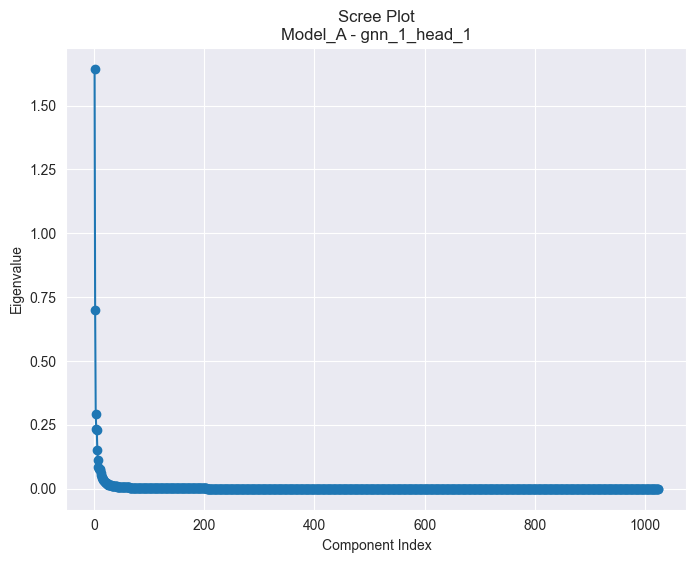

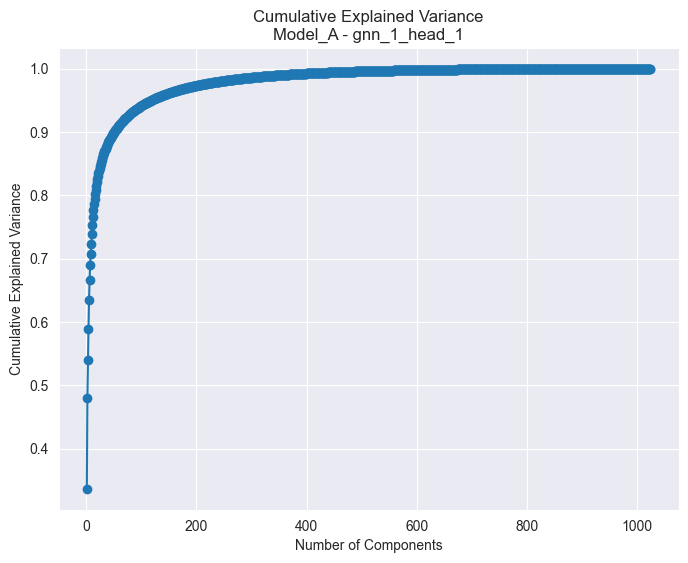

In [16]:
embeddings = np.load("/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_MSE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_03-35-19/gnn_1_head_2.npy")  # shape: (1988, 1024)
sorted_eigvals = compute_sorted_eigenvalues(embeddings)
plot_scree(sorted_eigvals, layer_name="gnn_1_head_1", model_name="Model_A", cumulative=False)
# To plot cumulative explained variance:
plot_scree(sorted_eigvals, layer_name="gnn_1_head_1", model_name="Model_A", cumulative=True)

In [17]:
eff_rank = compute_effective_rank(sorted_eigvals)
print("Effective rank:", eff_rank)

Effective rank: 23.436774216512347


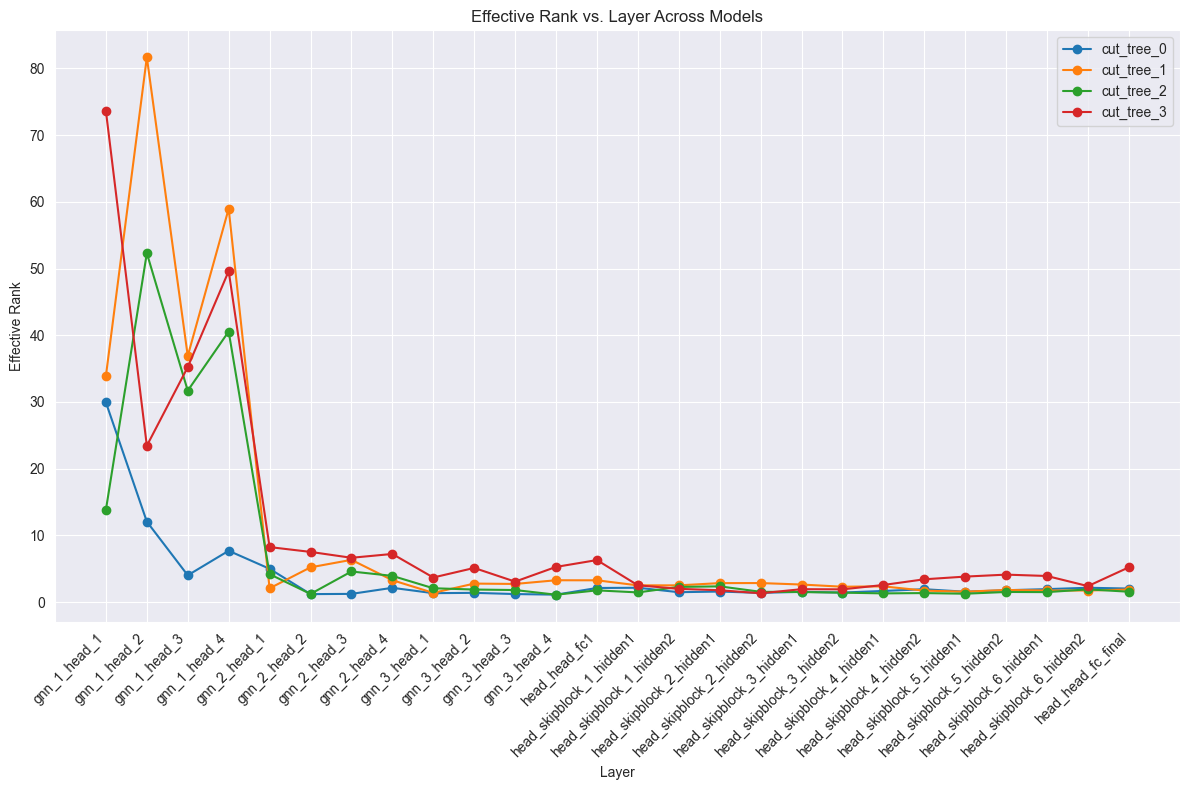

In [15]:
plot_effective_rank_vs_layer_multi(experiment_dirs, layer_names, model_label_func=extract_label)